## Loading data and preliminary analysis

In [4]:
# Download Dependencies

path_to_txt  =r'C:\\Users\\user\\OneDrive\\Desktop\\University\\Sem_5\\SKIH3013 PATTERN REGOGNITION\\Chatbot-for-mental-health\\requirements.txt'

import nltk 

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# import libraries

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.metrics import label_ranking_average_precision_score as mean_reciprocal_rank
from sklearn.metrics import ndcg_score



from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Conv1D, MaxPooling1D, SimpleRNN, GRU, LSTM, LSTM, Input, Embedding, TimeDistributed, Flatten, Dropout,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [6]:
# Modify Paths

path_to_json = r'mentalhealth.json'
path_to_dumps = '../Dumps/'

newpath = path_to_dumps
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [7]:
# load data
with open(path_to_json) as file:
  data = json.load(file)

# data

In [8]:
# convert to dataframes 
 
def frame_data(feat_1,feat_2,is_pattern, data):
  is_pattern = is_pattern
  df = pd.DataFrame(columns=[feat_1,feat_2])

  for intent in data['intents']:
    if is_pattern:
      for pattern in intent['patterns']:
        w = pattern
        data_to_append = {feat_1:w, feat_2:intent['tag']}
        df.loc[len(df)] = data_to_append
        
    else:
      for response in intent['responses']:
        w = response
        data_to_append = {feat_1:w, feat_2:intent['tag']}
        df.loc[len(df)] = data_to_append
  return df

In [9]:
df1 = frame_data('questions','labels',True, data)
# df1.head()

In [10]:
# no of patterns
df1.labels.value_counts(sort=False)

definition            3
affects_whom          2
what_causes           3
recover               2
steps                 2
find_help             2
treatement_options    2
treatment_tips        2
professional_types    2
right_professional    2
Name: labels, dtype: int64

In [11]:
df2 = frame_data('response','labels',False, data)
# df2.head()

## Data preprocessing

In [12]:
# preprocessing text

lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,path_to_dumps+'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return

In [13]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)   
        vocab.update(tokens)
    joblib.dump(vocab, path_to_dumps+'vocab.pkl')
    return

In [14]:
create_vocab(tokenizer,df1,'questions')

In [15]:
vocab

Counter({'what': 9,
         'doe': 3,
         'it': 2,
         'mean': 1,
         'to': 9,
         'have': 2,
         'mental': 14,
         'illness': 9,
         'is': 4,
         'health': 8,
         'describe': 1,
         'who': 3,
         'affect': 1,
         'affected': 1,
         'by': 1,
         'mentall': 1,
         'cause': 1,
         'lead': 1,
         'how': 7,
         'one': 2,
         'get': 1,
         'mentally': 1,
         'ill': 1,
         'can': 3,
         'people': 1,
         'with': 1,
         'recover': 3,
         'possible': 1,
         'from': 1,
         'know': 1,
         'someone': 1,
         'appears': 1,
         'such': 1,
         'symptom': 2,
         'are': 3,
         'the': 4,
         'step': 1,
         'be': 1,
         'followed': 1,
         'incase': 1,
         'of': 2,
         'find': 4,
         'professional': 6,
         'for': 1,
         'myself': 2,
         'treatment': 3,
         'option': 1,
         'avail

In [16]:
vocab_size = len(vocab)
vocab_size

62

In [17]:
df1.groupby(by='labels',as_index=False).first()['questions']

0                      Who does mental illness affect?
1          What does it mean to have a mental illness?
2    How to find mental health professional for myself
3    What is the difference between mental health p...
4              Can people with mental illness recover?
5    How can I find a mental health professional ri...
6    I know someone who appears to have such symptoms?
7                What treatment options are available?
8                 How to become involved in treatment?
9                          What causes mental illness?
Name: questions, dtype: object

In [18]:
# test_list contains the first element of questions

test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list

['Who does mental illness affect?',
 'What does it mean to have a mental illness?',
 'How to find mental health professional for myself',
 'What is the difference between mental health professionals?',
 'Can people with mental illness recover?',
 'How can I find a mental health professional right myself?',
 'I know someone who appears to have such symptoms?',
 'What treatment options are available?',
 'How to become involved in treatment?',
 'What causes mental illness?']

In [19]:
# indices of the testing dataset

test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index

[3, 0, 12, 18, 8, 20, 10, 14, 16, 5]

In [20]:
# train indices are the all indices minus the testing indices 

train_index = [i for i in df1.index if i not in test_index]
train_index 

[1, 2, 4, 6, 7, 9, 11, 13, 15, 17, 19, 21]

In [21]:
def convert_seq(df,feature):
#     text = ' '.join(list(vocab.keys()))
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    print(entries)
    print('----')
    t.fit_on_texts(entries)
    joblib.dump(t, path_to_dumps+'tokenizer_t.pkl')   # why a pkl file
    vocab_size = len(t.word_index) +1 # +1 for oov 
    print(t.word_index)
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    print('----')
    print("max length of string is : ",max_length)
    print('----')
    encoded = t.texts_to_sequences(entries)
    print(encoded)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    print('----')
    print(padded)
    return padded, vocab_size

In [22]:
X,vocab_size = convert_seq(df1,'questions')

['What does it mean to have a mental illness?', 'What is mental health illness', 'Describe mental health illness', 'Who does mental illness affect?', 'Who is affected by mentall illness', 'What causes mental illness?', 'What leads to mental illness?', 'how does one get mentally ill?', 'Can people with mental illness recover?', 'Is it possible to recover from mental illness', 'I know someone who appears to have such symptoms?', 'What are the steps to be followed incase of symptoms', 'How to find mental health professional for myself', 'How to find mental health professional?', 'What treatment options are available?', 'How can one recover?', 'How to become involved in treatment?', 'What should I keep in mind if I begin treatment?', 'What is the difference between mental health professionals?', 'What are the different types of mental health professionals present?', 'How can I find a mental health professional right myself?', 'How to find the right mental health professional?']
----
{'ment

In [23]:
with open(path_to_dumps+'tokenizer_t.pkl', 'rb') as f:
    data = pickle.load(f)

In [24]:
data.index_word

{1: 'mental',
 2: 'what',
 3: 'to',
 4: 'illness',
 5: 'health',
 6: 'how',
 7: 'is',
 8: 'i',
 9: 'the',
 10: 'find',
 11: 'professional',
 12: 'does',
 13: 'who',
 14: 'can',
 15: 'recover',
 16: 'are',
 17: 'treatment',
 18: 'it',
 19: 'have',
 20: 'a',
 21: 'one',
 22: 'symptoms',
 23: 'of',
 24: 'myself',
 25: 'in',
 26: 'professionals',
 27: 'right',
 28: 'mean',
 29: 'describe',
 30: 'affect',
 31: 'affected',
 32: 'by',
 33: 'mentall',
 34: 'causes',
 35: 'leads',
 36: 'get',
 37: 'mentally',
 38: 'ill',
 39: 'people',
 40: 'with',
 41: 'possible',
 42: 'from',
 43: 'know',
 44: 'someone',
 45: 'appears',
 46: 'such',
 47: 'steps',
 48: 'be',
 49: 'followed',
 50: 'incase',
 51: 'for',
 52: 'options',
 53: 'available',
 54: 'become',
 55: 'involved',
 56: 'should',
 57: 'keep',
 58: 'mind',
 59: 'if',
 60: 'begin',
 61: 'difference',
 62: 'between',
 63: 'different',
 64: 'types',
 65: 'present'}

In [25]:
data.word_counts

OrderedDict([('what', 9),
             ('does', 3),
             ('it', 2),
             ('mean', 1),
             ('to', 9),
             ('have', 2),
             ('a', 2),
             ('mental', 14),
             ('illness', 9),
             ('is', 4),
             ('health', 8),
             ('describe', 1),
             ('who', 3),
             ('affect', 1),
             ('affected', 1),
             ('by', 1),
             ('mentall', 1),
             ('causes', 1),
             ('leads', 1),
             ('how', 7),
             ('one', 2),
             ('get', 1),
             ('mentally', 1),
             ('ill', 1),
             ('can', 3),
             ('people', 1),
             ('with', 1),
             ('recover', 3),
             ('possible', 1),
             ('from', 1),
             ('i', 4),
             ('know', 1),
             ('someone', 1),
             ('appears', 1),
             ('such', 1),
             ('symptoms', 2),
             ('are', 3),
            

In [26]:
X

array([[ 2, 12, 18, 28,  3, 19, 20,  1,  4,  0],
       [ 2,  7,  1,  5,  4,  0,  0,  0,  0,  0],
       [29,  1,  5,  4,  0,  0,  0,  0,  0,  0],
       [13, 12,  1,  4, 30,  0,  0,  0,  0,  0],
       [13,  7, 31, 32, 33,  4,  0,  0,  0,  0],
       [ 2, 34,  1,  4,  0,  0,  0,  0,  0,  0],
       [ 2, 35,  3,  1,  4,  0,  0,  0,  0,  0],
       [ 6, 12, 21, 36, 37, 38,  0,  0,  0,  0],
       [14, 39, 40,  1,  4, 15,  0,  0,  0,  0],
       [ 7, 18, 41,  3, 15, 42,  1,  4,  0,  0],
       [ 8, 43, 44, 13, 45,  3, 19, 46, 22,  0],
       [ 2, 16,  9, 47,  3, 48, 49, 50, 23, 22],
       [ 6,  3, 10,  1,  5, 11, 51, 24,  0,  0],
       [ 6,  3, 10,  1,  5, 11,  0,  0,  0,  0],
       [ 2, 17, 52, 16, 53,  0,  0,  0,  0,  0],
       [ 6, 14, 21, 15,  0,  0,  0,  0,  0,  0],
       [ 6,  3, 54, 55, 25, 17,  0,  0,  0,  0],
       [ 2, 56,  8, 57, 25, 58, 59,  8, 60, 17],
       [ 2,  7,  9, 61, 62,  1,  5, 26,  0,  0],
       [ 2, 16,  9, 63, 64, 23,  1,  5, 26, 65],
       [ 6, 14,  8, 

In [27]:
vocab_size

66

In [28]:
df_encoded = pd.DataFrame(X)

In [29]:
df_encoded

,0,1,2,3,4,5,6,7,8,9
0,2,12,18,28,3,19,20,1,4,0
1,2,7,1,5,4,0,0,0,0,0
2,29,1,5,4,0,0,0,0,0,0
3,13,12,1,4,30,0,0,0,0,0
4,13,7,31,32,33,4,0,0,0,0
5,2,34,1,4,0,0,0,0,0,0
6,2,35,3,1,4,0,0,0,0,0
7,6,12,21,36,37,38,0,0,0,0
8,14,39,40,1,4,15,0,0,0,0
9,7,18,41,3,15,42,1,4,0,0


In [30]:
df1.head(10)

,questions,labels
0,What does it mean to have a mental illness?,definition
1,What is mental health illness,definition
2,Describe mental health illness,definition
3,Who does mental illness affect?,affects_whom
4,Who is affected by mentall illness,affects_whom
5,What causes mental illness?,what_causes
6,What leads to mental illness?,what_causes
7,how does one get mentally ill?,what_causes
8,Can people with mental illness recover?,recover
9,Is it possible to recover from mental illness,recover


In [31]:
df_encoded['labels'] = df1.labels
df_encoded.head(10)

,0,1,2,3,4,5,6,7,8,9,labels
0,2,12,18,28,3,19,20,1,4,0,definition
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
3,13,12,1,4,30,0,0,0,0,0,affects_whom
4,13,7,31,32,33,4,0,0,0,0,affects_whom
5,2,34,1,4,0,0,0,0,0,0,what_causes
6,2,35,3,1,4,0,0,0,0,0,what_causes
7,6,12,21,36,37,38,0,0,0,0,what_causes
8,14,39,40,1,4,15,0,0,0,0,recover
9,7,18,41,3,15,42,1,4,0,0,recover


In [32]:
df_encoded

,0,1,2,3,4,5,6,7,8,9,labels
0,2,12,18,28,3,19,20,1,4,0,definition
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
3,13,12,1,4,30,0,0,0,0,0,affects_whom
4,13,7,31,32,33,4,0,0,0,0,affects_whom
5,2,34,1,4,0,0,0,0,0,0,what_causes
6,2,35,3,1,4,0,0,0,0,0,what_causes
7,6,12,21,36,37,38,0,0,0,0,what_causes
8,14,39,40,1,4,15,0,0,0,0,recover
9,7,18,41,3,15,42,1,4,0,0,recover


In [33]:
lable_enc = LabelEncoder()

# encoding the labels

labl = lable_enc.fit_transform(df_encoded.labels)
labl

array([1, 1, 1, 0, 0, 9, 9, 9, 4, 4, 6, 6, 2, 2, 7, 7, 8, 8, 3, 3, 5, 5])

In [34]:
len(labl)

22

In [35]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'definition': 1,
 'affects_whom': 0,
 'what_causes': 9,
 'recover': 4,
 'steps': 6,
 'find_help': 2,
 'treatement_options': 7,
 'treatment_tips': 8,
 'professional_types': 3,
 'right_professional': 5}

Repeat the same for df2

In [36]:
df2.head()

,response,labels
0,Mental illnesses are health conditions that di...,definition
1,It is estimated that mental illness affects 1 ...,affects_whom
2,Symptoms of mental health disorders vary depen...,what_causes
3,"When healing from mental illness, early identi...",recover
4,Although this website cannot substitute for pr...,steps


In [37]:
df2

,response,labels
0,Mental illnesses are health conditions that di...,definition
1,It is estimated that mental illness affects 1 ...,affects_whom
2,Symptoms of mental health disorders vary depen...,what_causes
3,"When healing from mental illness, early identi...",recover
4,Although this website cannot substitute for pr...,steps
5,Feeling comfortable with the professional you ...,find_help
6,Just as there are different types of medicatio...,treatement_options
7,Since beginning treatment is a big step for in...,treatment_tips
8,There are many types of mental health professi...,professional_types
9,Feeling comfortable with the professional you ...,right_professional


In [38]:
df2.labels = df2.labels.map(mapper).astype({'labels': 'int32'})
df2.head()

,response,labels
0,Mental illnesses are health conditions that di...,1
1,It is estimated that mental illness affects 1 ...,0
2,Symptoms of mental health disorders vary depen...,9
3,"When healing from mental illness, early identi...",4
4,Although this website cannot substitute for pr...,6


In [39]:
df2.to_csv('response.csv',index=False)

In [40]:
df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,labels
0,2,12,18,28,3,19,20,1,4,0,definition
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
3,13,12,1,4,30,0,0,0,0,0,affects_whom
4,13,7,31,32,33,4,0,0,0,0,affects_whom


In [41]:
train_index

[1, 2, 4, 6, 7, 9, 11, 13, 15, 17, 19, 21]

In [42]:
test_index

[3, 0, 12, 18, 8, 20, 10, 14, 16, 5]

In [43]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

## Training and testing

In [44]:
train

,0,1,2,3,4,5,6,7,8,9,labels
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
4,13,7,31,32,33,4,0,0,0,0,affects_whom
6,2,35,3,1,4,0,0,0,0,0,what_causes
7,6,12,21,36,37,38,0,0,0,0,what_causes
9,7,18,41,3,15,42,1,4,0,0,recover
11,2,16,9,47,3,48,49,50,23,22,steps
13,6,3,10,1,5,11,0,0,0,0,find_help
15,6,14,21,15,0,0,0,0,0,0,treatement_options
17,2,56,8,57,25,58,59,8,60,17,treatment_tips


In [45]:
test.head()

,0,1,2,3,4,5,6,7,8,9,labels
3,13,12,1,4,30,0,0,0,0,0,affects_whom
0,2,12,18,28,3,19,20,1,4,0,definition
12,6,3,10,1,5,11,51,24,0,0,find_help
18,2,7,9,61,62,1,5,26,0,0,professional_types
8,14,39,40,1,4,15,0,0,0,0,recover


In [46]:
train.labels.value_counts()

definition            2
what_causes           2
affects_whom          1
recover               1
steps                 1
find_help             1
treatement_options    1
treatment_tips        1
professional_types    1
right_professional    1
Name: labels, dtype: int64

In [47]:
test.labels.value_counts()

affects_whom          1
definition            1
find_help             1
professional_types    1
recover               1
right_professional    1
steps                 1
treatement_options    1
treatment_tips        1
what_causes           1
Name: labels, dtype: int64

In [48]:
train

,0,1,2,3,4,5,6,7,8,9,labels
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
4,13,7,31,32,33,4,0,0,0,0,affects_whom
6,2,35,3,1,4,0,0,0,0,0,what_causes
7,6,12,21,36,37,38,0,0,0,0,what_causes
9,7,18,41,3,15,42,1,4,0,0,recover
11,2,16,9,47,3,48,49,50,23,22,steps
13,6,3,10,1,5,11,0,0,0,0,find_help
15,6,14,21,15,0,0,0,0,0,0,treatement_options
17,2,56,8,57,25,58,59,8,60,17,treatment_tips


In [49]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels

In [50]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9
1,2,7,1,5,4,0,0,0,0,0
2,29,1,5,4,0,0,0,0,0,0
4,13,7,31,32,33,4,0,0,0,0
6,2,35,3,1,4,0,0,0,0,0
7,6,12,21,36,37,38,0,0,0,0


In [51]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values

In [52]:
X_test

,0,1,2,3,4,5,6,7,8,9
3,13,12,1,4,30,0,0,0,0,0
0,2,12,18,28,3,19,20,1,4,0
12,6,3,10,1,5,11,51,24,0,0
18,2,7,9,61,62,1,5,26,0,0
8,14,39,40,1,4,15,0,0,0,0
20,6,14,8,10,20,1,5,11,27,24
10,8,43,44,13,45,3,19,46,22,0
14,2,17,52,16,53,0,0,0,0,0
16,6,3,54,55,25,17,0,0,0,0
5,2,34,1,4,0,0,0,0,0,0


In [53]:
X_train

,0,1,2,3,4,5,6,7,8,9
1,2,7,1,5,4,0,0,0,0,0
2,29,1,5,4,0,0,0,0,0,0
4,13,7,31,32,33,4,0,0,0,0
6,2,35,3,1,4,0,0,0,0,0
7,6,12,21,36,37,38,0,0,0,0
9,7,18,41,3,15,42,1,4,0,0
11,2,16,9,47,3,48,49,50,23,22
13,6,3,10,1,5,11,0,0,0,0
15,6,14,21,15,0,0,0,0,0,0
17,2,56,8,57,25,58,59,8,60,17


In [54]:
y_train

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=uint8)

In [55]:
y_train[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [56]:
y_test

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [57]:
y_train[0].shape,y_test[0].shape

((10,), (10,))

In [58]:
X_train.shape

(12, 10)

In [59]:
X_test.shape

(10, 10)

In [60]:
max_length = X_train.shape[1]
output = 16                  # no of classes

In [61]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10) #patience

checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [early_stopping,checkpoint,reduce_lr]

## Vanilla RNN

In [62]:
def define_model1(vocab_size, max_length):
    model1 = Sequential()
    model1.add(Embedding(vocab_size,100, input_length=max_length))
    model1.add(SimpleRNN(100))
    model1.add(Dense(10, activation='softmax'))   
    
    model1.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model1.summary()
    plot_model(model1, to_file='model_1.png', show_shapes=True)
    return model1

In [63]:
model1 = define_model1(vocab_size, max_length)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           6600      
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
Total params: 27710 (108.24 KB)
Trainable params: 27710 (108.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [64]:
history1 = model1.fit(X_train, y_train, epochs=50, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)#,callbacks=callbacks)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming model1.predict returns the predicted labels
y_pred = np.argmax(model1.predict(X_test), axis=1)

# Assuming y_test contains the actual labels
y_test_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, F1-score, and accuracy
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')
accuracy = accuracy_score(y_test_labels, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Epoch 1/50




1/1 [==============================] - ETA: 0s - loss: 2.3348 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 2.30011, saving model to model-v1.h5
1/1 [==============================] - 2s 2s/step - loss: 2.3348 - accuracy: 0.0000e+00 - val_loss: 2.3001 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2.1994 - accuracy: 0.4167
Epoch 2: val_loss improved from 2.30011 to 2.28784, saving model to model-v1.h5
1/1 [==============================] - 0s 42ms/step - loss: 2.1994 - accuracy: 0.4167 - val_loss: 2.2878 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2.0687 - accuracy: 0.7500
Epoch 3: val_loss improved from 2.28784 to 2.27736, saving model to model-v1.h5
1/1 [==============================] - 0s 44ms/step - loss: 2.0687 - accuracy: 0.7500 - val_loss: 2.2774 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 41ms/step - loss: 1.8127 - accuracy: 0.9167 - val_loss: 2.2615 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 1.6850 - accuracy: 0.9167
Epoch 6: val_loss improved from 2.26148 to 2.25627, saving model to model-v1.h5
1/1 [==============================] - 0s 42ms/step - loss: 1.6850 - accuracy: 0.9167 - val_loss: 2.2563 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - ETA: 0s - loss: 1.5566 - accuracy: 0.9167
Epoch 7: val_loss improved from 2.25627 to 2.25263, saving model to model-v1.h5
1/1 [==============================] - 0s 50ms/step - loss: 1.5566 - accuracy: 0.9167 - val_loss: 2.2526 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 8/50
1/1 [==============================] - ETA: 0s - loss: 1.4274 - accuracy: 0.9167
Epoch 8: val_loss improved from 2.25263 to 2.24986, saving model to model-v1.h5
1/1 [==============================] - 0s 42ms/step - loss: 1

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


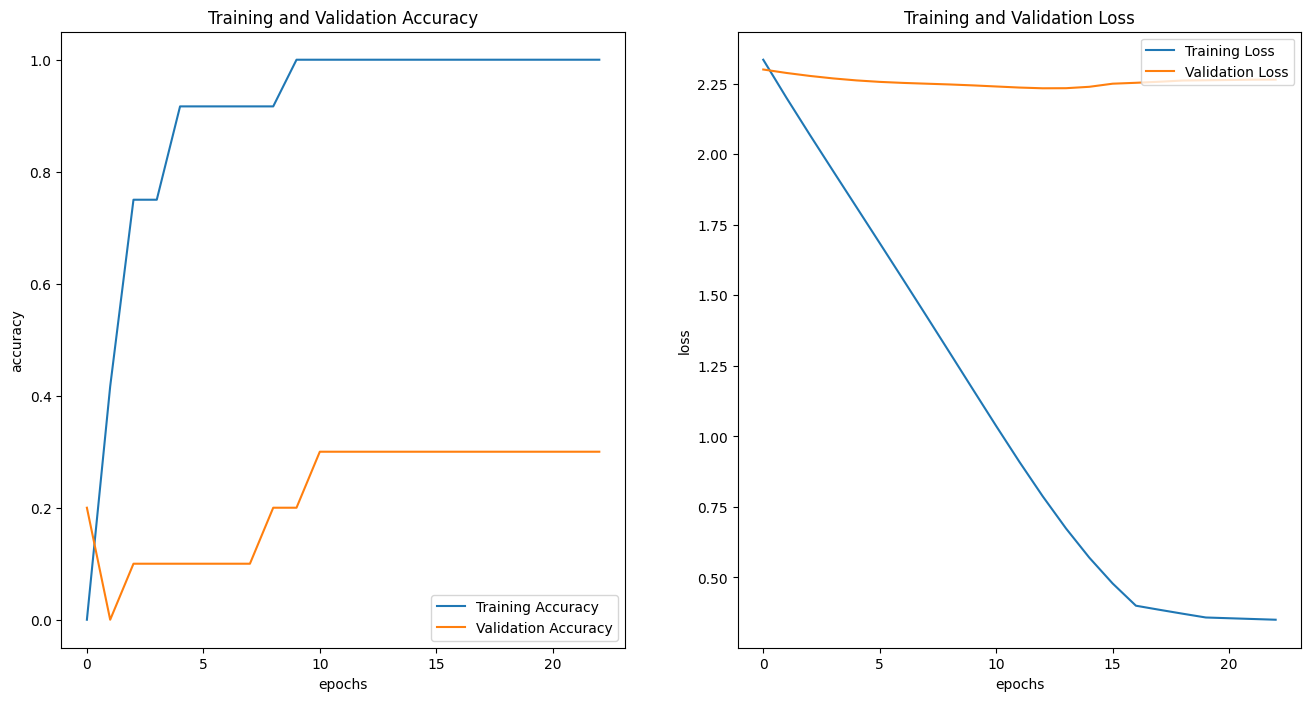

In [65]:
# Learning curves 

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## CNN

In [66]:
def define_model2(vocab_size, max_length):
    model2 = Sequential()
    model2.add(Embedding(vocab_size,300, input_length=max_length))
    model2.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    model2.add(MaxPooling1D(pool_size = 4))
    model2.add(Flatten())
    model2.add(Dense(32, activation='relu'))
    model2.add(Dense(10, activation='softmax'))
    
    model2.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model2.summary()
    return model2

In [67]:
model2 = define_model2(vocab_size, max_length)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 300)           19800     
                                                                 
 conv1d (Conv1D)             (None, 9, 32)             19232     
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 32)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                     

In [68]:
history = model2.fit(X_train, y_train, epochs=50, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming model1.predict returns the predicted labels
y_pred = np.argmax(model2.predict(X_test), axis=1)

# Assuming y_test contains the actual labels
y_test_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, F1-score, and accuracy
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')
accuracy = accuracy_score(y_test_labels, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 2.3135 - accuracy: 0.0833
Epoch 1: val_loss did not improve from 2.23355
1/1 [==============================] - 1s 767ms/step - loss: 2.3135 - accuracy: 0.0833 - val_loss: 2.3076 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 2.2665 - accuracy: 0.4167
Epoch 2: val_loss did not improve from 2.23355
1/1 [==============================] - 0s 28ms/step - loss: 2.2665 - accuracy: 0.4167 - val_loss: 2.3060 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 2.2332 - accuracy: 0.4167
Epoch 3: val_loss did not improve from 2.23355
1/1 [==============================] - 0s 27ms/step - loss: 2.2332 - accuracy: 0.4167 - val_loss: 2.3043 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 2.2046 - accuracy: 0.6667
Epoch 4: val_loss did not improve from 2.23355
1/1 [===============

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 42/50
1/1 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.9167
Epoch 42: val_loss improved from 2.20848 to 2.20253, saving model to model-v1.h5
1/1 [==============================] - 0s 40ms/step - loss: 0.6288 - accuracy: 0.9167 - val_loss: 2.2025 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 43/50
1/1 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.9167
Epoch 43: val_loss improved from 2.20253 to 2.19610, saving model to model-v1.h5
1/1 [==============================] - 0s 41ms/step - loss: 0.5890 - accuracy: 0.9167 - val_loss: 2.1961 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 44/50
1/1 [==============================] - ETA: 0s - loss: 0.5501 - accuracy: 0.9167
Epoch 44: val_loss improved from 2.19610 to 2.18899, saving model to model-v1.h5
1/1 [==============================] - 0s 43ms/step - loss: 0.5501 - accuracy: 0.9167 - val_loss: 2.1890 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 45/50
1/1 [==============================] - ETA:

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


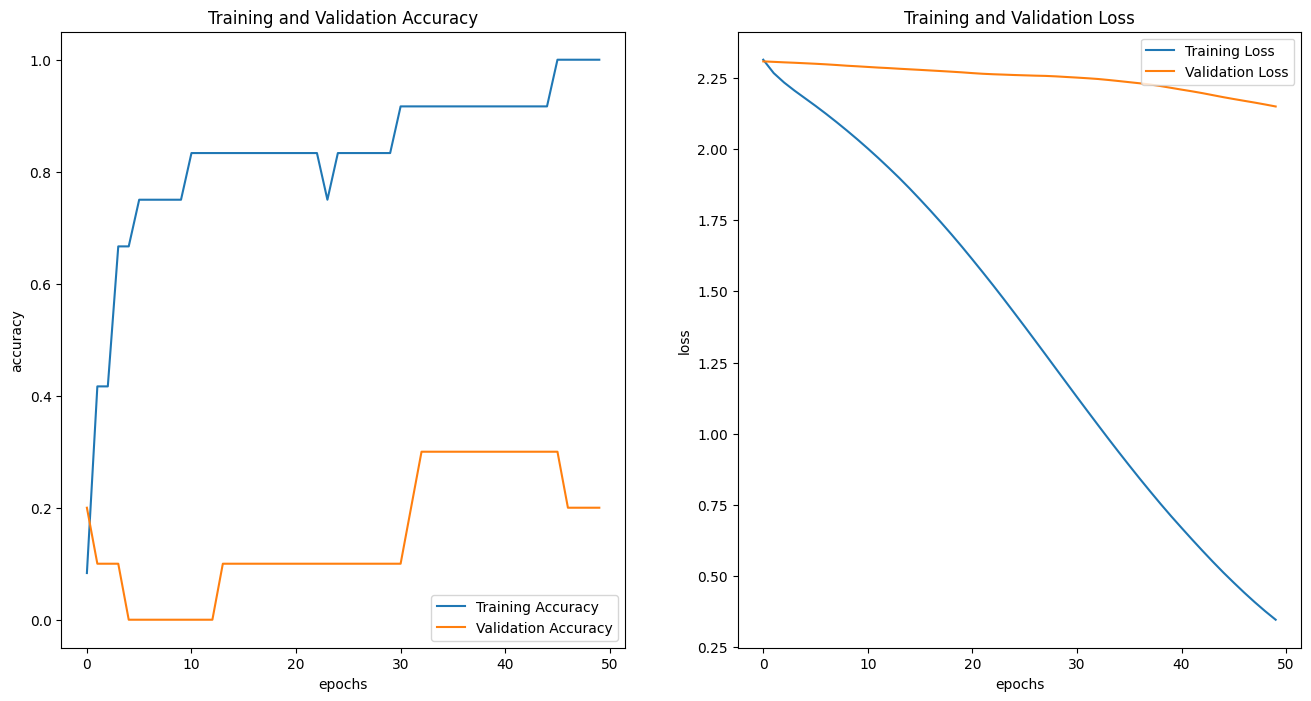

In [69]:
# Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## LSTM

In [70]:
def define_model3(vocab_size, max_length):
    model3 = Sequential()
    model3.add(Embedding(vocab_size,300, input_length=max_length))
    model3.add(LSTM(500))
    model3.add(Dense(10, activation='softmax'))
    
    model3.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model3.summary()
    return model3

In [71]:
model3 = define_model3(vocab_size, max_length)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 300)           19800     
                                                                 
 lstm (LSTM)                 (None, 500)               1602000   
                                                                 
 dense_3 (Dense)             (None, 10)                5010      
                                                                 
Total params: 1626810 (6.21 MB)
Trainable params: 1626810 (6.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
history = model3.fit(X_train, y_train, epochs=50, verbose=1,validation_data=(X_test,y_test))

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming model1.predict returns the predicted labels
y_pred = np.argmax(model3.predict(X_test), axis=1)

# Assuming y_test contains the actual labels
y_test_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, F1-score, and accuracy
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')
accuracy = accuracy_score(y_test_labels, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 2.3018 - accuracy: 0.1667 - val_loss: 2.2928 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 62ms/step - loss: 2.2452 - accuracy: 0.3333 - val_loss: 2.2851 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 62ms/step - loss: 2.1866 - accuracy: 0.4167 - val_loss: 2.2806 - val_accuracy: 0.1000
Epoch 4/50
1/1 [==============================] - 0s 57ms/step - loss: 2.1186 - accuracy: 0.4167 - val_loss: 2.2846 - val_accuracy: 0.1000
Epoch 5/50
1/1 [==============================] - 0s 69ms/step - loss: 2.0362 - accuracy: 0.4167 - val_loss: 2.3129 - val_accuracy: 0.1000
Epoch 6/50
1/1 [==============================] - 0s 56ms/step - loss: 1.9419 - accuracy: 0.4167 - val_loss: 2.3883 - val_accuracy: 0.1000
Epoch 7/50
1/1 [==============================] - 0s 59ms/step - loss: 1.8503 - accuracy: 0.4167 - val_loss: 2.4718 - val_accuracy: 0.0000e+00
Epoch 8/50
1/1 [=

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


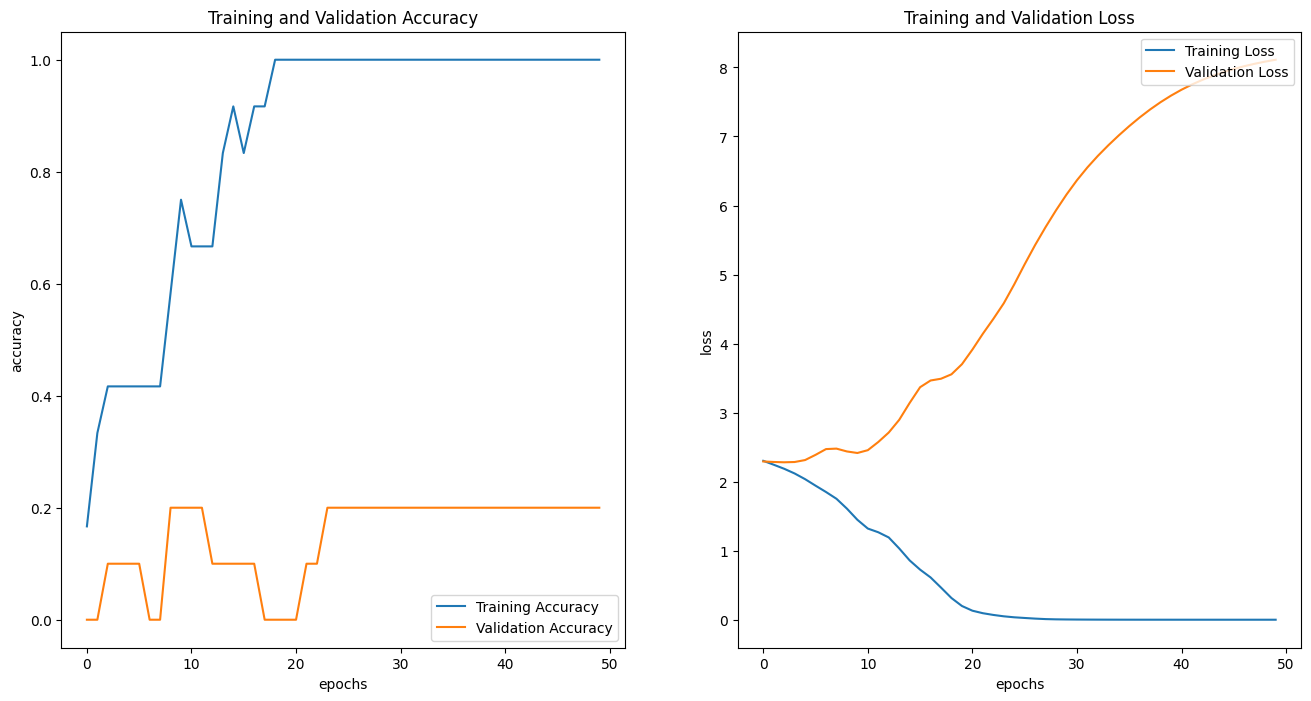

In [73]:
# Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## GRU

In [74]:
def define_model4(vocab_size, max_length):
    model4 = Sequential()
    model4.add(Embedding(vocab_size,300, input_length=max_length))
    model4.add(GRU(500))
    model4.add(Dense(10, activation='softmax'))
    
    model4.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model4.summary()
    return model4

In [75]:
model4 = define_model4(vocab_size, max_length)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 300)           19800     
                                                                 
 gru (GRU)                   (None, 500)               1203000   
                                                                 
 dense_4 (Dense)             (None, 10)                5010      
                                                                 
Total params: 1227810 (4.68 MB)
Trainable params: 1227810 (4.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
history = model4.fit(X_train, y_train, epochs=50, verbose=1,validation_data=(X_test,y_test))

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming model1.predict returns the predicted labels
y_pred = np.argmax(model4.predict(X_test), axis=1)

# Assuming y_test contains the actual labels
y_test_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, F1-score, and accuracy
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')
accuracy = accuracy_score(y_test_labels, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 2.3006 - accuracy: 0.0833 - val_loss: 2.2961 - val_accuracy: 0.2000
Epoch 2/50
1/1 [==============================] - 0s 46ms/step - loss: 2.2375 - accuracy: 0.3333 - val_loss: 2.2965 - val_accuracy: 0.1000
Epoch 3/50
1/1 [==============================] - 0s 45ms/step - loss: 2.1749 - accuracy: 0.4167 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 4/50
1/1 [==============================] - 0s 47ms/step - loss: 2.1083 - accuracy: 0.4167 - val_loss: 2.3208 - val_accuracy: 0.1000
Epoch 5/50
1/1 [==============================] - 0s 46ms/step - loss: 2.0360 - accuracy: 0.4167 - val_loss: 2.3592 - val_accuracy: 0.1000
Epoch 6/50
1/1 [==============================] - 0s 51ms/step - loss: 1.9603 - accuracy: 0.4167 - val_loss: 2.4252 - val_accuracy: 0.1000
Epoch 7/50
1/1 [==============================] - 0s 50ms/step - loss: 1.8857 - accuracy: 0.4167 - val_loss: 2.4959 - val_accuracy: 0.1000
Epoch 8/50
1/1 [=============

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


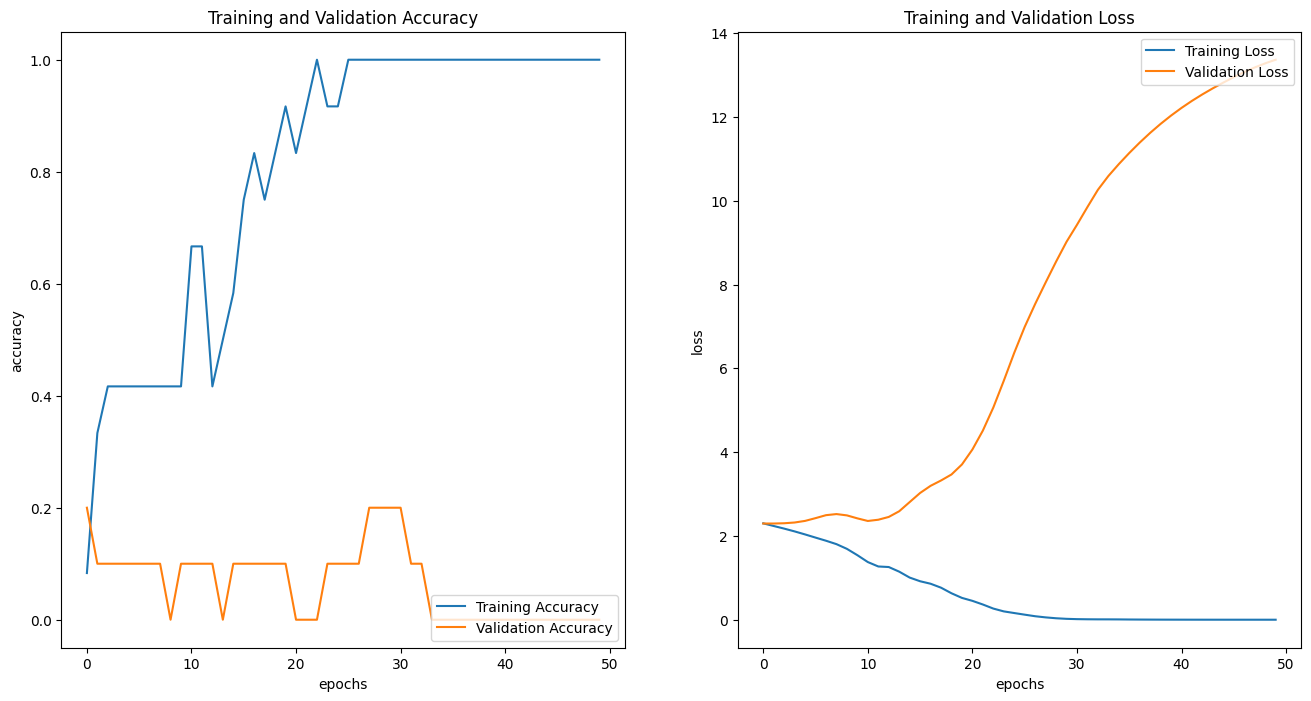

In [77]:
# Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## BiLSTM


In [78]:
def define_model5(vocab_size, max_length):
    model5 = Sequential()
    model5.add(Embedding(vocab_size,300, input_length=max_length))
    model5.add(Bidirectional(LSTM(500)))
    model5.add(Dense(10, activation='softmax'))
    
    model5.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model5.summary()
    return model5

In [79]:
model5 = define_model5(vocab_size, max_length)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 300)           19800     
                                                                 
 bidirectional (Bidirection  (None, 1000)              3204000   
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 10)                10010     
                                                                 
Total params: 3233810 (12.34 MB)
Trainable params: 3233810 (12.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
X_train.shape

(12, 10)

In [81]:
y_train.shape

(12, 10)

In [82]:
history = model5.fit(X_train, y_train, epochs=50, verbose=1,validation_data=(X_test,y_test))

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming model1.predict returns the predicted labels
y_pred = np.argmax(model5.predict(X_test), axis=1)

# Assuming y_test contains the actual labels
y_test_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, F1-score, and accuracy
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')
accuracy = accuracy_score(y_test_labels, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Epoch 1/50


1/1 [==============================] - 3s 3s/step - loss: 2.3046 - accuracy: 0.0833 - val_loss: 2.2913 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 81ms/step - loss: 2.2359 - accuracy: 0.5000 - val_loss: 2.2813 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 84ms/step - loss: 2.1641 - accuracy: 0.5000 - val_loss: 2.2751 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 83ms/step - loss: 2.0803 - accuracy: 0.5000 - val_loss: 2.2814 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 82ms/step - loss: 1.9790 - accuracy: 0.5000 - val_loss: 2.3299 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 82ms/step - loss: 1.8683 - accuracy: 0.5000 - val_loss: 2.4621 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 82ms/step - loss: 1.7766 - accuracy: 0.5000 - val_loss: 2.5144 - val_accuracy: 0.0000e+00
Epoch 8/50
1

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


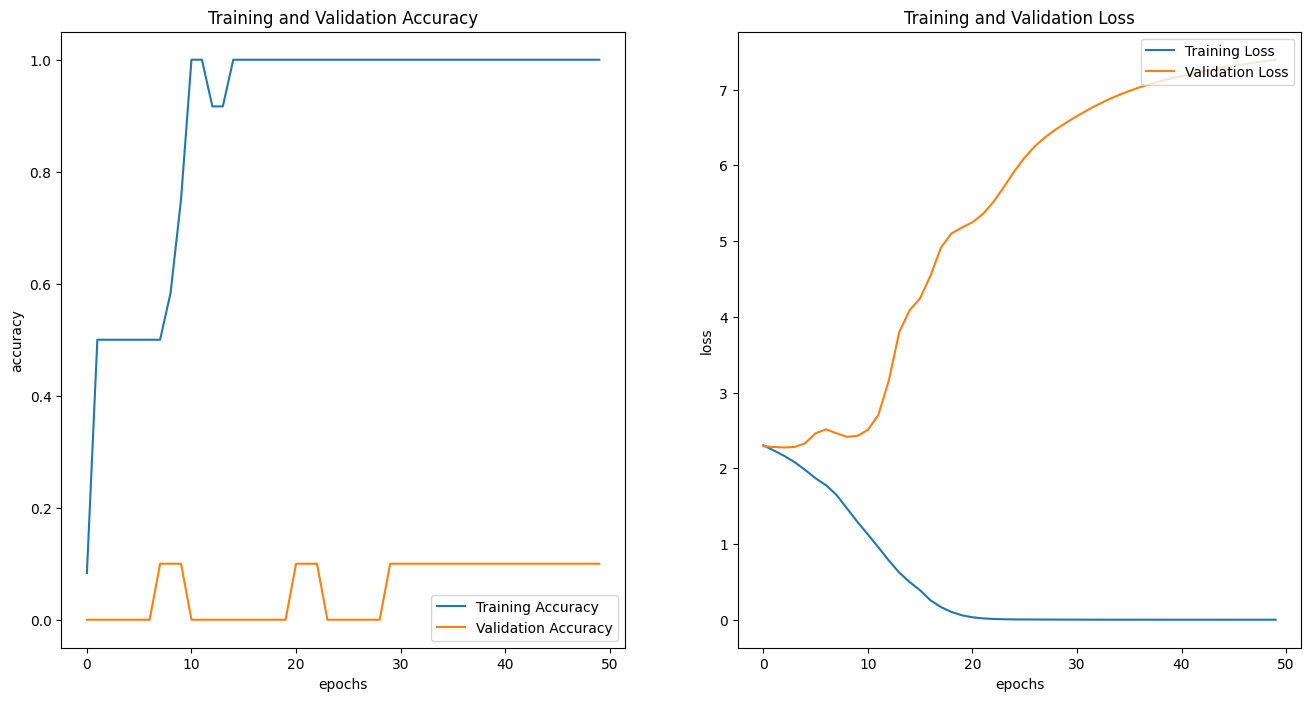

In [83]:
# Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Predictions

In [84]:
tf.get_logger().setLevel('ERROR')

In [85]:
def get_text(str_text):
    # print(str_text)
    input_text  = [str_text]
    df_input = pd.DataFrame(input_text,columns=['questions'])
    df_input
    return df_input

In [86]:
model = model2 = model3 = model4 = model5
tokenizer_t = joblib.load(path_to_dumps+'tokenizer_t.pkl')
vocab = joblib.load(path_to_dumps+'vocab.pkl')

In [87]:
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
    # stop_words = set(stopwords.words('english'))
    # tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [88]:
def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df

In [89]:
def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=10, padding='post')
    return padded

In [90]:
def get_pred(model,encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    return pred

In [91]:
def bot_precausion(df_input,pred):
    words = df_input.questions[0].split()
    if len([w for w in words if w in vocab])==0 :
        pred = 1
    return pred

In [92]:
def get_response(df2,pred):
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).response)
    return responses[r]

In [93]:
def bot_response(response,):
    print(response)

In [94]:
from collections import Counter


input_text = "Can people recover from mental illness?"

# Create a new DataFrame with the new input
df_input = get_text(input_text)

#load artifacts 
tokenizer_t = joblib.load(r'C:\Users\user\OneDrive\Desktop\University\Sem_5\SKIH3013 PATTERN REGOGNITION\mentalhealth - Copy\Dumps\tokenizer_t.pkl')
vocab = joblib.load(r'C:\Users\user\OneDrive\Desktop\University\Sem_5\SKIH3013 PATTERN REGOGNITION\mentalhealth - Copy\Dumps\vocab.pkl')


df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred1 = get_pred(model1,encoded_input)
pred2 = get_pred(model2,encoded_input)
pred3 = get_pred(model3,encoded_input)
pred4 = get_pred(model4,encoded_input)
pred5 = get_pred(model5,encoded_input)

pred1 = bot_precausion(df_input,pred1)
pred2 = bot_precausion(df_input,pred2)
pred3 = bot_precausion(df_input,pred3)
pred4 = bot_precausion(df_input,pred4)
pred5 = bot_precausion(df_input,pred5)

response1 = get_response(df2,pred1)
response2 = get_response(df2,pred2)
response3 = get_response(df2,pred3)
response4 = get_response(df2,pred4)
response5 = get_response(df2,pred5)

models = [model1, model2, model3, model4, model5]

# Display the input and responses
for i, model in enumerate(models, start=1):
    model_pred = get_pred(model, encoded_input)
    model_pred = bot_precausion(df_input, model_pred)
    model_response = get_response(df2, model_pred)
    bot_response(f"Model{i}: {model_response}")

# Get predictions from all models for the new input
all_predictions = [get_pred(model, encoded_input) for model in models]

# Use Counter to find the most common prediction
final_prediction = Counter(all_predictions).most_common(1)[0][0]

# Get response based on the final prediction
final_response = get_response(df2, final_prediction)

# Display the final response
bot_response("Final Response: " + final_response)

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 18ms/step
Model1: It is estimated that mental illness affects 1 in 5 adults in America, and that 1 in 24 adults have a serious mental illness.
1/1 [==============================] - 0s 20ms/step
Model2: Just as there are different types of medications for physical illness, different treatment options are available for individuals with mental illness. Treatment works differently for different people. It is important to find what works best for you or your child.
1/1 [==============================] - 0s 19ms/step
Model3: Just as there are different types of medications for physical illness, different treatment options are available for individuals with mental illness. Treatment works differently for different people. It is important to find what works best for you or your child.
1/1 [==============================] - 0s 19ms/step
Model4: Just as there are different types of medications for physical illness, different treatment options are availa

In [95]:
from collections import Counter


input_text = "How can someone find a mental health professional for themselves?"

# Create a new DataFrame with the new input
df_input = get_text(input_text)

#load artifacts 
tokenizer_t = joblib.load(r'C:\Users\user\OneDrive\Desktop\University\Sem_5\SKIH3013 PATTERN REGOGNITION\mentalhealth - Copy\Dumps\tokenizer_t.pkl')
vocab = joblib.load(r'C:\Users\user\OneDrive\Desktop\University\Sem_5\SKIH3013 PATTERN REGOGNITION\mentalhealth - Copy\Dumps\vocab.pkl')


df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred1 = get_pred(model1,encoded_input)
pred2 = get_pred(model2,encoded_input)
pred3 = get_pred(model3,encoded_input)
pred4 = get_pred(model4,encoded_input)
pred5 = get_pred(model5,encoded_input)

pred1 = bot_precausion(df_input,pred1)
pred2 = bot_precausion(df_input,pred2)
pred3 = bot_precausion(df_input,pred3)
pred4 = bot_precausion(df_input,pred4)
pred5 = bot_precausion(df_input,pred5)

response1 = get_response(df2,pred1)
response2 = get_response(df2,pred2)
response3 = get_response(df2,pred3)
response4 = get_response(df2,pred4)
response5 = get_response(df2,pred5)

models = [model1, model2, model3, model4, model5]

# Display the input and responses
for i, model in enumerate(models, start=1):
    model_pred = get_pred(model, encoded_input)
    model_pred = bot_precausion(df_input, model_pred)
    model_response = get_response(df2, model_pred)
    bot_response(f"Model{i}: {model_response}")

# Get predictions from all models for the new input
all_predictions = [get_pred(model, encoded_input) for model in models]

# Use Counter to find the most common prediction
final_prediction = Counter(all_predictions).most_common(1)[0][0]

# Get response based on the final prediction
final_response = get_response(df2, final_prediction)

# Display the final response
bot_response("Final Response: " + final_response)

1/1 [==============================] - 0s 17ms/step
Model1: Feeling comfortable with the professional you or your child is working with is critical to the success of your treatment. Finding the professional who best fits your needs may require some research.
1/1 [==============================] - 0s 19ms/step
Model2: Just as there are different types of medications for physical illness, different treatment options are available for individuals with mental illness. Treatment works differently for different people. It is important to find what works best for you or your child.
1/1 [==============================] - 0s 20ms/step
Model3: Just as there are different types of medications for physical illness, different treatment options are available for individuals with mental illness. Treatment works differently for different people. It is important to find what works best for you or your child.
1/1 [==============================] - 0s 19ms/step
Model4: Just as there are different types o

In [96]:
from collections import Counter


input_text = "Can you describe common symptoms of specific mental health disorders?"

# Create a new DataFrame with the new input
df_input = get_text(input_text)

#load artifacts 
tokenizer_t = joblib.load(r'C:\Users\user\OneDrive\Desktop\University\Sem_5\SKIH3013 PATTERN REGOGNITION\mentalhealth - Copy\Dumps\tokenizer_t.pkl')
vocab = joblib.load(r'C:\Users\user\OneDrive\Desktop\University\Sem_5\SKIH3013 PATTERN REGOGNITION\mentalhealth - Copy\Dumps\vocab.pkl')


df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred1 = get_pred(model1,encoded_input)
pred2 = get_pred(model2,encoded_input)
pred3 = get_pred(model3,encoded_input)
pred4 = get_pred(model4,encoded_input)
pred5 = get_pred(model5,encoded_input)

pred1 = bot_precausion(df_input,pred1)
pred2 = bot_precausion(df_input,pred2)
pred3 = bot_precausion(df_input,pred3)
pred4 = bot_precausion(df_input,pred4)
pred5 = bot_precausion(df_input,pred5)

response1 = get_response(df2,pred1)
response2 = get_response(df2,pred2)
response3 = get_response(df2,pred3)
response4 = get_response(df2,pred4)
response5 = get_response(df2,pred5)

models = [model1, model2, model3, model4, model5]

# Display the input and responses
for i, model in enumerate(models, start=1):
    model_pred = get_pred(model, encoded_input)
    model_pred = bot_precausion(df_input, model_pred)
    model_response = get_response(df2, model_pred)
    bot_response(f"Model{i}: {model_response}")

# Get predictions from all models for the new input
all_predictions = [get_pred(model, encoded_input) for model in models]

# Use Counter to find the most common prediction
final_prediction = Counter(all_predictions).most_common(1)[0][0]

# Get response based on the final prediction
final_response = get_response(df2, final_prediction)

# Display the final response
bot_response("Final Response: " + final_response)

1/1 [==============================] - 0s 17ms/step
Model1: Feeling comfortable with the professional you or your child is working with is critical to the success of the treatment. Finding the professional who best fits your needs may require research. Start by searching for providers in your area.
1/1 [==============================] - 0s 19ms/step
Model2: Mental illnesses are health conditions that disrupt a person's thoughts, emotions, relationships, and daily functioning.
1/1 [==============================] - 0s 19ms/step
Model3: Mental illnesses are health conditions that disrupt a person's thoughts, emotions, relationships, and daily functioning.
1/1 [==============================] - 0s 19ms/step
Model4: Mental illnesses are health conditions that disrupt a person's thoughts, emotions, relationships, and daily functioning.
1/1 [==============================] - 0s 19ms/step
Model5: Mental illnesses are health conditions that disrupt a person's thoughts, emotions, relationships,

In [97]:
# Save Model Weights
model1.save('model1_weights.h5')
model2.save('model2_weights.h5')
model3.save('model3_weights.h5')
model4.save('model4_weights.h5')
model5.save('model5_weights.h5')
# Save Label Encoder Mapping
joblib.dump(mapper, 'label_encoder_mapping.pkl')

# Save Training Data Indices
joblib.dump(train_index, 'train_index.pkl')
joblib.dump(test_index, 'test_index.pkl')

# Save Training History
with open('history1.pkl', 'wb') as f:
    pickle.dump(history1.history, f)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Assuming X_train and X_test are your tokenized and padded text data
cv = CountVectorizer()
df_bow = pd.DataFrame(cv.fit_transform(X_train.astype(str).apply(' '.join)).toarray(), columns=cv.get_feature_names_out())

tfidf = TfidfVectorizer()
df_tfidf = pd.DataFrame(tfidf.fit_transform(X_train.astype(str).apply(' '.join)).toarray(), columns=tfidf.get_feature_names_out())




# Save Artifacts for Retrieval
joblib.dump(cv, 'count_vectorizer_retrievalbased.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer_retrievalbased.pkl')
df_bow.to_csv('df_bow_retrievalbased.csv', index=False)
df_tfidf.to_csv('df_tfidf_retrievalbased.csv', index=False)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [98]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the saved model
model1 = load_model('model1_weights.h5')

# Make predictions on the test set
y_pred_model1 = model1.predict(X_test)

# Convert predictions to labels
y_pred_labels_model1 = np.argmax(y_pred_model1, axis=1)

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix_model1 = confusion_matrix(y_true_labels, y_pred_labels_model1)

# Display confusion matrix
print("Confusion Matrix - Model 1:")
print(conf_matrix_model1)

# Display classification report
print("Classification Report - Model 1:")
print(classification_report(y_true_labels, y_pred_labels_model1))


1/1 [==============================] - 0s 109ms/step
Confusion Matrix - Model 1:
[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]
Classification Report - Model 1:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.33      1.00      0.50         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.30        10
   ma

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [99]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the saved model
model2 = load_model('model2_weights.h5')

# Make predictions on the test set
y_pred_model2 = model2.predict(X_test)

# Convert predictions to labels
y_pred_labels_model2 = np.argmax(y_pred_model2, axis=1)

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix_model2 = confusion_matrix(y_true_labels, y_pred_labels_model2)

# Display confusion matrix
print("Confusion Matrix - Model 2:")
print(conf_matrix_model2)

# Display classification report
print("Classification Report - Model 2:")
print(classification_report(y_true_labels, y_pred_labels_model2))


1/1 [==============================] - 1s 509ms/step
Confusion Matrix - Model 2:
[[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]]
Classification Report - Model 2:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.10        10
   ma

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [100]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the saved model
model3 = load_model('model3_weights.h5')

# Make predictions on the test set
y_pred_model3 = model3.predict(X_test)

# Convert predictions to labels
y_pred_labels_model3 = np.argmax(y_pred_model3, axis=1)

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix_model3 = confusion_matrix(y_true_labels, y_pred_labels_model3)

# Display confusion matrix
print("Confusion Matrix - Model 3:")
print(conf_matrix_model3)

# Display classification report
print("Classification Report - Model 3:")
print(classification_report(y_true_labels, y_pred_labels_model3))


1/1 [==============================] - 0s 499ms/step
Confusion Matrix - Model 3:
[[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]]
Classification Report - Model 3:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.10        10
   ma

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [101]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the saved model
model4 = load_model('model4_weights.h5')

# Make predictions on the test set
y_pred_model4 = model4.predict(X_test)

# Convert predictions to labels
y_pred_labels_model4 = np.argmax(y_pred_model4, axis=1)

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix_model4 = confusion_matrix(y_true_labels, y_pred_labels_model4)

# Display confusion matrix
print("Confusion Matrix - Model 4:")
print(conf_matrix_model4)

# Display classification report
print("Classification Report - Model 4:")
print(classification_report(y_true_labels, y_pred_labels_model4))


1/1 [==============================] - 1s 510ms/step
Confusion Matrix - Model 4:
[[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]]
Classification Report - Model 4:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.10        10
   ma

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [102]:
from sklearn.metrics import confusion_matrix, classification_report

# Load the saved model
model5 = load_model('model5_weights.h5')

# Make predictions on the test set
y_pred_model5 = model3.predict(X_test)

# Convert predictions to labels
y_pred_labels_model5 = np.argmax(y_pred_model5, axis=1)

# Convert one-hot encoded true labels to labels
y_true_labels = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix_model5 = confusion_matrix(y_true_labels, y_pred_labels_model5)

# Display confusion matrix
print("Confusion Matrix - Model 5:")
print(conf_matrix_model5)

# Display classification report
print("Classification Report - Model 5:")
print(classification_report(y_true_labels, y_pred_labels_model5))


1/1 [==============================] - 0s 41ms/step
Confusion Matrix - Model 5:
[[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]]
Classification Report - Model 5:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.10        10
   mac

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

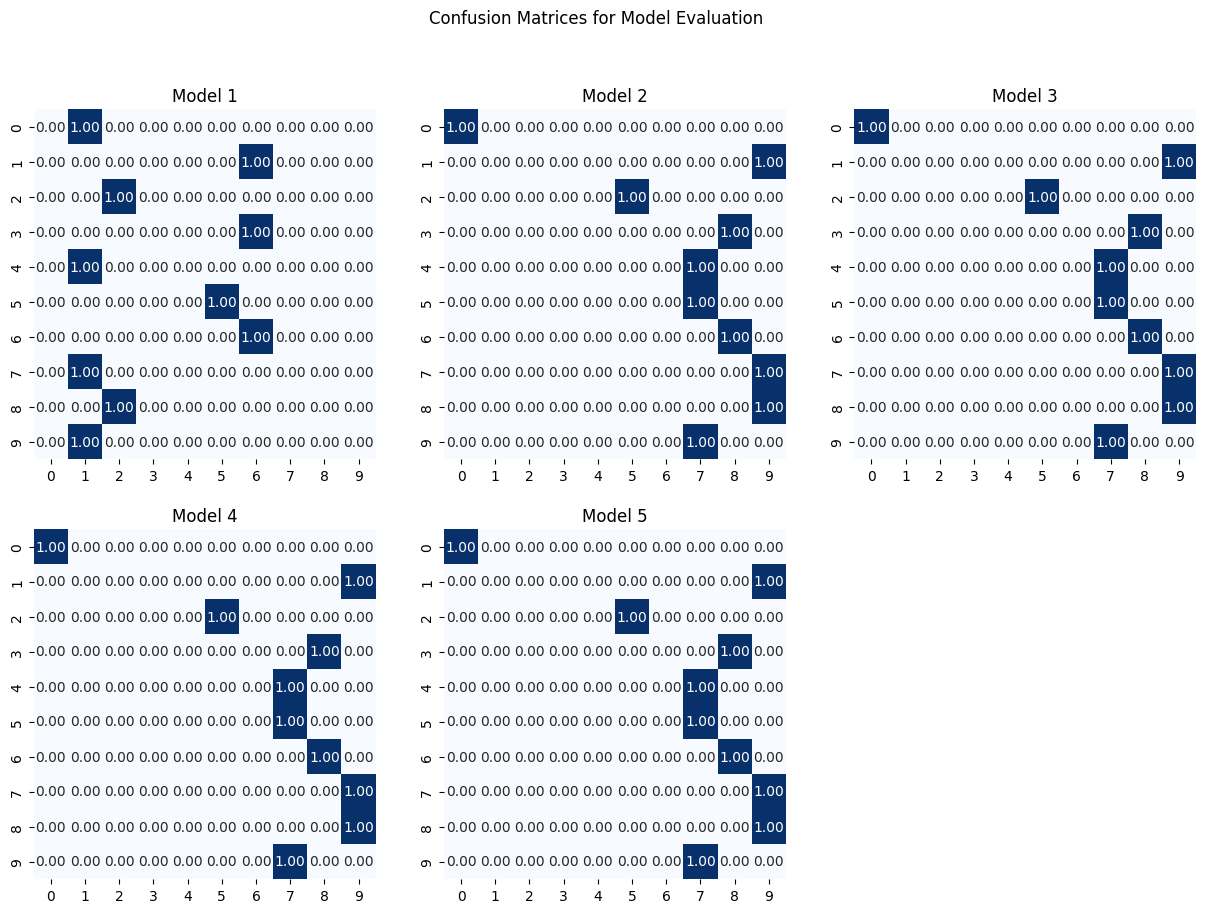

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have results for all five models (confusion matrices)
conf_matrix_model1 = confusion_matrix(y_true_labels, y_pred_labels_model1)
conf_matrix_model2 = confusion_matrix(y_true_labels, y_pred_labels_model2)
conf_matrix_model3 = confusion_matrix(y_true_labels, y_pred_labels_model3)
conf_matrix_model4 = confusion_matrix(y_true_labels, y_pred_labels_model4)
conf_matrix_model5 = confusion_matrix(y_true_labels, y_pred_labels_model5)

# Combine all confusion matrices into a list
conf_matrices = [conf_matrix_model1, conf_matrix_model2, conf_matrix_model3, conf_matrix_model4, conf_matrix_model5]

# Determine the number of rows and columns for subplots
num_rows = 2  # Adjust as needed
num_cols = 3  # Adjust as needed

# Plotting
plt.figure(figsize=(15, 10))

for i, conf_matrix in enumerate(conf_matrices, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.title(f"Model {i}")

plt.suptitle("Confusion Matrices for Model Evaluation")
plt.show()
